# Compare HTEX to Threads for NWChem Ensembles
The tradeoff are likely that HTEx consumes more resources but has lower overhead for running large numbers of tasks, as it creates separate Python interpreters.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import linregress
from pathlib import Path
import pandas as pd
import numpy as np
import json
import re

Get the run parameters

In [2]:
down_select = "mode=='hessian' and nodes_per_task==2"

## Find all the runs
Look for the run config directory

In [3]:
run_files = list(Path('runs').glob('**/run_params.json'))

In [4]:
results = pd.DataFrame([json.loads(r.read_text()) for r in run_files])
results['path'] = [p.parent for p in run_files]

In [5]:
results.query(down_select, inplace=True)

## Compute MOM Node Utilization
We want to know how much memory is used and the total CPU utilization

In [6]:
def assess_utilization(path: Path) -> dict:
    """Compute the memory and CPU utilization statistics
    
    Args:
        path: Path to the run directory
    Returns:
        (dict) Description of the inputs
    """
    
    util = pd.read_json(path / 'usage.json', lines=True)
    return {
        'mem_max': util['all_mem'].max() / 1024 ** 2,
        'cpu_max': util['all_cpu'].max(),
        'cpu_mean': util['all_cpu'].mean(),
    }

In [7]:
results = results.join(pd.DataFrame(results['path'].apply(assess_utilization).to_list()))

In [8]:
results[['config', 'nnodes', 'mem_max']].sort_values(['config', 'nnodes'])

,config,nnodes,mem_max
8,htex,2,371.352539
9,htex,4,499.282227
1,htex,8,717.361328
2,htex,128,7080.495117
6,htex,256,13788.324219
0,thread,2,259.693359
5,thread,4,282.362305
4,thread,8,286.370117
7,thread,128,518.754883
3,thread,256,855.776367


htex: 288.5 + N * 105.6 MiB - R = 1.00
thread: 260.2 + N * 4.5 MiB - R = 1.00


Text(0, 0.5, 'Max Memory Usage (MiB)')

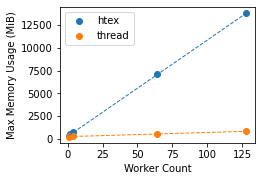

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

for gid, group in results.groupby('config'):
    # Plot the results
    group = group.sort_values('nnodes')
    l = ax.scatter(group['qc_workers'], group['mem_max'], label=gid)
    
    # Determine the relationship with node count
    r = linregress(group['qc_workers'], group['mem_max'])
    x = np.linspace(group['qc_workers'].min(), group['qc_workers'].max(), 128)
    y = r.intercept + x * r.slope
    ax.plot(x, y, '--', lw=1)
    print(f'{gid}: {r.intercept:.1f} + N * {r.slope:.1f} MiB - R = {r.rvalue:.2f}')

ax.legend()
ax.set_xlabel('Worker Count')
ax.set_ylabel('Max Memory Usage (MiB)')

*Finding*: We save a lot of memory using the ThreadPoolExecutor

htex: -35.4 + N * 6.8 % - R = 0.95
thread: 10.4 + N * 0.6 % - R = 0.91


Text(0, 0.5, 'Max CPU Usage (%)')

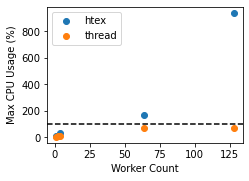

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

for gid, group in results.groupby('config'):
    # Plot the results
    group = group.sort_values('nnodes')
    l = ax.scatter(group['qc_workers'], group['cpu_max'], label=gid)
    
    # Determine the relationship with node count
    r = linregress(group['qc_workers'], group['cpu_max'])
    x = np.linspace(group['qc_workers'].min(), group['nnodes'].max(), 128)
    y = r.intercept + x * r.slope
    print(f'{gid}: {r.intercept:.1f} + N * {r.slope:.1f} % - R = {r.rvalue:.2f}')
    
ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [100]*2, 'k--')

ax.legend()
ax.set_xlabel('Worker Count')
ax.set_ylabel('Max CPU Usage (%)')

*Finding*: We do start to hit the single-threaded limit with the thread pool executor.

## Study the Overhead
We want to know if running multiple threads interferes with execution runtime, and if having many in an ensemble cuases other problems with the launch system

In [11]:
nwc_walltime_re = re.compile('wall:\s+([0-9]+\.[0-9]+)s')

In [12]:
def assess_overhead(path: Path) -> dict:
    """Assess the overhead on the NWChem computations:
    
        - Launch overhead: How much time is spent executing and processing NWChem
            Walltime of QCEngine call - walltime of NWChem
        - Wrapper overhead: How much time is spent preparing for NWChem call (e.g., generating XYZ)
            Walltime of Colmena function - Walltime of QCEngine Call
        - Colmena overhead: How much time is spent moving task request and results
            Time between submission and result - Walltime of Colmena Function
        - Total overead: How much time is spent doing _anything_ besides NWChem
            Time between submission and result - walltime of NWChem
    """
    
    # Evaluate the difference between QCEngine walltime and NWChem
    qce_walltimes = []
    nwc_walltimes = []
    with open(path / 'qcfractal-records.json') as fp:
        for line in fp:
            # Get the NWC and QCE walltimes
            qcf = json.loads(line)
            qce_walltimes.append(qcf['provenance']['wall_time'])
            nwc_walltimes.append(float(nwc_walltime_re.findall(qcf['stdout'])[0]))
    
    # Load in the result summaries
    results = pd.read_json(path / 'simulation-results.json', lines=True)
    results['makespan'] = results['time_result_received'] - results['time_created']
    
    outputs = {
        'launch_overhead': np.subtract(qce_walltimes, nwc_walltimes),
        'wrapper_overhead': np.subtract(results.query('success')['time_running'], qce_walltimes).values,
        'colmena_overhead': (results['makespan'] - results['time_running']).values,
        'total_overhead': np.subtract(results.query('success')['makespan'], nwc_walltimes).values
    }
    for c in list(outputs.keys()):
        outputs[c + '_median'] = np.percentile(outputs[c], 50)
    return outputs

In [13]:
assess_overhead(results['path'][0])

{'launch_overhead': array([21.65562873, 10.02654605,  9.91008272, 10.44037261]),
 'wrapper_overhead': array([1.14609634e+01, 1.07737409e-02, 1.65147083e-02, 1.42774079e-02]),
 'colmena_overhead': array([0.2906359 , 0.00809423, 0.00813253, 0.00784211, 0.00269903,
        0.00249969]),
 'total_overhead': array([33.40722804, 10.04541402,  9.93472996, 10.46249213]),
 'launch_overhead_median': 10.233459329605068,
 'wrapper_overhead_median': 0.015396058093756437,
 'colmena_overhead_median': 0.00796817141235806,
 'total_overhead_median': 10.253953075408901}

In [14]:
%%time
overheads = pd.DataFrame(results['path'].apply(assess_overhead).to_list())

CPU times: user 2.1 s, sys: 2.29 s, total: 4.38 s
Wall time: 4.46 s


In [15]:
for c in ['nnodes', 'qc_workers', 'config']:
    overheads[c] = results[c]

Plot the breakdown

Text(0, 0.5, 'Overhead (s)')

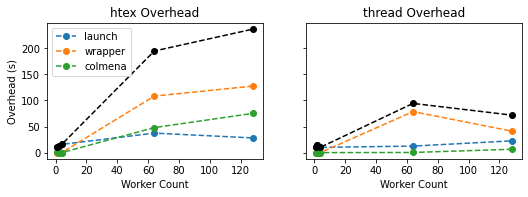

In [16]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8.5, 2.5))

for ax, (gid, group) in zip(axs, overheads.groupby('config')):
    group = group.sort_values('nnodes')
    for c in ['launch', 'wrapper', 'colmena']:
        ax.plot(group['qc_workers'], group[f'{c}_overhead_median'], '--o', label=c)
    
    ax.plot(group['qc_workers'], group['total_overhead_median'], 'k--o')
    
    ax.set_title(f'{gid} Overhead')
    ax.set_xlabel('Worker Count')
    
axs[0].legend()
axs[0].set_ylabel('Overhead (s)')

*Finding*: We do observe increasing colmena overhead as we increase the worker count and that the increase is slower with Threads.